<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/DiD_Modern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern DiD Approaches



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

In [2]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'pyfixest'])
except ImportError:
    pass

import pyfixest as pf

The data is from [Callaway (2022)](https://bcallaway11.github.io/files/Callaway-Chapter-2022/main.pdf), annual county level data from the United States covering 2001 to 2007. The outcome variable is log county-level teen employment, and the treatment variable is an indicator for whether the county has a minimum wage above the federal minimum wage. See [Callaway and Sant’Anna (2021)](https://www.sciencedirect.com/science/article/abs/pii/S0304407620303948) for additional details on the data.

In [3]:
url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv"
data = pd.read_csv(url,index_col=0)

# Remove observations that are already treated in the first observed period (2001).
data = data.loc[(data.G == 0) | (data.G > 2001)]

# Drop all variables that we won't use
data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)

data.head(10)

,year,treated,G,lemp,lpop,lavg_pay,region,id
554,2001,0,2007,5.556828,9.614137,10.057495,4,8003
555,2002,0,2007,5.356586,9.623972,10.097120,4,8003
556,2003,0,2007,5.389072,9.620859,10.107611,4,8003
557,2004,0,2007,5.356586,9.626548,10.140337,4,8003
558,2005,0,2007,5.303305,9.637958,10.175497,4,8003
559,2006,0,2007,5.342334,9.633056,10.218590,4,8003
560,2007,1,2007,5.220356,9.635412,10.289702,4,8003
561,2001,0,2007,5.198497,9.260368,10.021359,4,8007
562,2002,0,2007,5.262690,9.312265,10.031045,4,8007
563,2003,0,2007,5.278115,9.338118,10.071795,4,8007


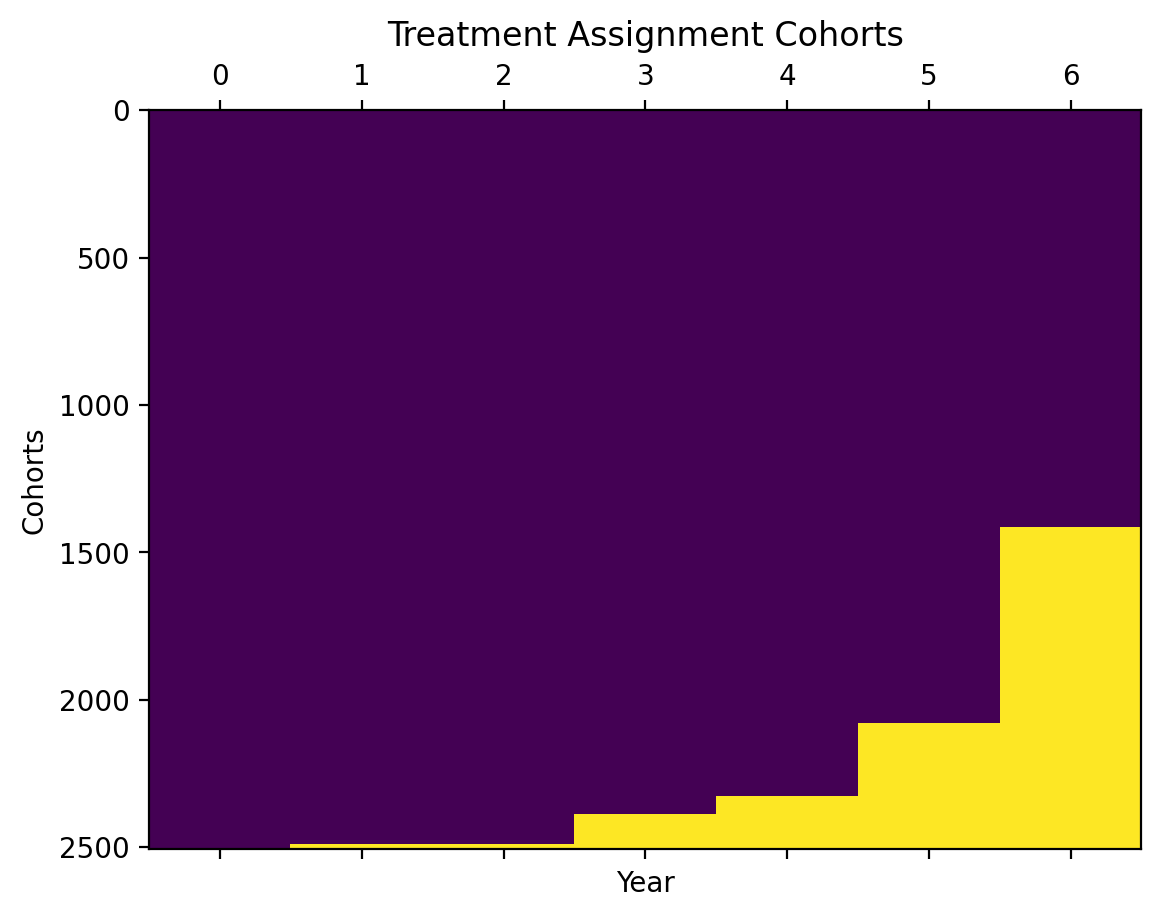

In [6]:
# Visualize the treatment cohorts using panelview
pf.panelview(
    data,
    unit="id",
    time="year",
    treat="treated",
    sort_by_timing=True,
    ylab="Cohorts",
    xlab="Year",
    title="Treatment Assignment Cohorts",
    figsize=(0.5, 0.5),
)

plt.show()

#This graph shows when all the cohorts get treated. On the Y axis it's the number of counties.

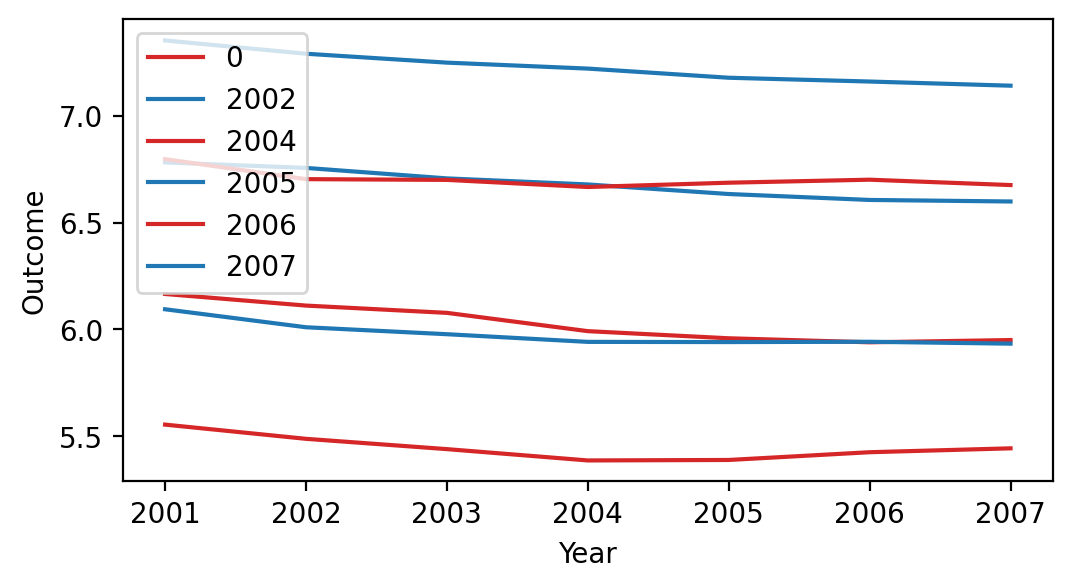

In [15]:
# Visualize the trends of employment for each treatment cohort
fig, ax = plt.subplots(figsize=(6, 3))

# Calculate means and standard errors
means = data.groupby(["year", "G"])["lemp"].mean().unstack()
std_errors = data.groupby(["year", "G"])["lemp"].sem().unstack()

# Plot means
means.plot(ax=ax, color=['tab:red', 'tab:blue'])

# Add legend, vertical line, labels, and show plot
plt.legend(loc="upper left")
plt.xlabel("Year")
plt.ylabel("Outcome")
plt.show()

#there are a lot of treatment cohorts and it's hard to see evident paralell trends.

Even though we know the problems of using TWFE with staggered adoption, we will use it as a benchmark to compare with the other methods.

In [20]:
# TWFE no dynamics
fit_static_twfe = pf.feols("lemp ~ treated | id + year",
                           data, vcov={"CRV1": "id"})
fit_static_twfe.summary()

#shows tht when a county is treated (has a minimum wage above federal wage), the lemp (outcome) is lower by 3 percent.
#can make sense from a theory perspective.

###

Estimation:  OLS
Dep. var.: lemp, Fixed effects: id+year
Inference:  CRV1
Observations:  17549

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| treated       |     -0.035 |        0.006 |    -6.189 |      0.000 | -0.046 |  -0.024 |
---
RMSE: 0.13 R2: 0.993 R2 Within: 0.003 


In [ ]:
# prompt: create a relative year

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import subprocess
import google.colab
import pyfixest as pf

warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

# Installation on Google Colab
try:
    subprocess.run(['python', '-m', 'pip', 'install', 'pyfixest'])
except ImportError:
    pass

url = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/minwage_data.csv"
data = pd.read_csv(url,index_col=0)

# Remove observations that are already treated in the first observed period (2001).
data = data.loc[(data.G == 0) | (data.G > 2001)]

# Drop all variables that we won't use
data.drop(columns=["countyreal", "state_name", "FIPS", "emp0A01_BS",
                   "quarter", "censusdiv", "pop", "annual_avg_pay",
                   "state_mw", "fed_mw", "ever_treated"], inplace=True)


# Create relative year
data['relative_year'] = data.groupby('id')['year'].transform(lambda x: x - x.min())

data.head(10)

In [25]:
# TWFE with dynamic treatment effects
data["relative_year"]= np.where(data['G']>0, data['year']-data['G'], -np.inf)

fit_dynamic_twfe = pf.feols("lemp ~ i(relative_year, treated, ref = -1.0) | id + year",
                            data, vcov={"CRV1": "id"})

dynamic_twfe.iplot(
        coord_flip = False,
        title= 'Ugly Plot',
        figsize= [800, 300],
        xintercept = 4.5,
        yintercept = 5.0



        )


fit_dynamic_twfe.summary()

NameError: name 'dynamic_twfe' is not defined

## Callaway and Sant'Anna (2020)

CS propose two ways of dealing with the negative weights.

1. Compare average outcomes in any post-adoption period $(\bar{Y}_{t \mid a} \text{ for } t \geq a)$ to average outcomes for the same group immediately prior to the adoption $(\bar{Y}_{a-1 \mid a})$. Then, subtract the difference in outcomes for the same two time periods for the single group that never adopts the treatment $(a=\infty)$. Formally, for $t \geq a$, this double difference is
$$
\hat{\tau}_{t, a-1}^{a, \infty}=\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\left(\bar{Y}_{t \mid \infty}-\bar{Y}_{a-1 \mid \infty}\right) .
$$

2. Same as above, but instead of using the group that never adopts the treatment as the control group, use the average of the groups that do adopt the treatment, but restrict this to those who adopt after period $t$.
$$
\hat{\tau}_{t, a-1}^{a,>t} \equiv\left(\bar{Y}_{t \mid a}-\bar{Y}_{a-1 \mid a}\right)-\frac{1}{T-t} \sum_{a^{\prime}=t+1}^T\left(\bar{Y}_{t \mid a^{\prime}}-\bar{Y}_{a-1 \mid a^{\prime}}\right)
$$

3. Given these two estimators, CS suggest reporting averages over periods $t$ and adoption dates $a$, using a variety of possible weight functions $\omega(a, t)$. This leads to an average of treatment effects, over different adoption dates, at exactly $e$ periods after adoption, for their two control groups,
$$
\hat{\tau}^{\mathrm{CS}, \mathrm{I}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a, \infty}, \quad \text { or } \quad \hat{\tau}^{\mathrm{CS}, \mathrm{II}}(e)=\sum_{a=2}^{T-e} \omega_e(a, t) \cdot \hat{\tau}_{t, a-1}^{a,>t} .
$$

A concern is that the control group that never adopts the treatment might be fundamentally different from the other groups and thus less suitable as a comparison for the trends in the absence of the treatment.

In [28]:
!pip install csdid

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 kB 35.4 MB/s eta 0:00:00
  Created wheel for csdid: filename=csdid-0.2.5-py3-none-any.whl size=22349 sha256=e5157d8f86d64fc9b4a193d065aec7b6c159aed5112542cab740f0eb80658af1
  Stored in directory: /root/.cache/pip/wheels/b7/ed/ce/85e1d7548d898fddfa839d8947d1be93af80b8c62d3e724da3
Successfully built csdid
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.


In [27]:
from csdid.att_gt import ATTgt

# Estimate group-time average treatment effects without covariates
attgt = ATTgt(yname= 'lemp', gname='G', idname='id', tname='year', data=data).fit()
attgt.summ_attgt().summary()

ModuleNotFoundError: No module named 'csdid'

In [ ]:
# Plot the treatment effects by group



In [ ]:
# Agreggated treatment effect



In [ ]:
# Agreggated by group



In [ ]:
# Agreggated by time



What happen if we introduce covariates? And what if we use the not-yet-adopted group as control group?